# Per 100 poss.

In [1]:
import pandas as pd
import numpy as np

import ml_project_functions as functions

from matplotlib import pyplot as plt
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import RobustScaler
import xgboost as xgb

# Data acquisition

In [2]:
# data acquisition from fs

dir_path = ".\\Datasets"

training_per_100_poss = pd.read_json(dir_path + "\\training_per_100_poss_players.json")
test_per_100_poss = pd.read_json(dir_path + "\\test_per_100_poss_players.json")  # test set: False    81, True     19

print("# righe per 100 poss : ", training_per_100_poss.shape[0])  # 3367 righe
print(training_per_100_poss['Hof'].value_counts())  # False #   3295, True       72

print("# righe hof per 100 poss: ", test_per_100_poss.shape[0])  # 100 righe
print(test_per_100_poss['Hof'].value_counts())

# righe per 100 poss :  3367
Hof
False    3295
True       72
Name: count, dtype: int64
# righe hof per 100 poss:  100
Hof
False    81
True     19
Name: count, dtype: int64


# General data preparation

In [3]:
def dataset_preparation(n_df):
    n_df = n_df[(n_df['G'] >= 100)]  # n_df = n_df[(n_df['To'] - n_df['From'] >= 3)]
    n_df.set_index(pd.Index([i for i in range(n_df.shape[0])]))
    n_df['Hof'] = n_df['Hof'].astype(int)  # n_df.loc[:, 'Hof'] = n_df['Hof'].astype(int)

    if 'PER' in list(n_df.columns):
        n_df = n_df.drop(columns=['Unnamed: 14', 'Unnamed: 16', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 21',
                                  'Unnamed: 23', 'Unnamed: 24'])
    else:
        n_df = n_df.drop(columns=['Unnamed: 22', 'Unnamed: 23', 'Unnamed: 29'])

    return n_df.fillna(0).sample(frac=1, random_state=23)

In [4]:
# general data preparation 

training_per_100_poss_prepared = dataset_preparation(training_per_100_poss.copy())
training_per_100_poss_prepared['O/DRtg'] = training_per_100_poss_prepared['ORtg'] - training_per_100_poss_prepared['DRtg']
print("Training dataset size after preparation: ", training_per_100_poss_prepared.shape[0])

test_per_100_poss_prepared = dataset_preparation(test_per_100_poss.copy())
test_per_100_poss_prepared['O/DRtg'] = test_per_100_poss_prepared['ORtg'] - test_per_100_poss_prepared['DRtg']
print("Test dataset size after preparation: ", test_per_100_poss_prepared.shape[0])

Training dataset size after preparation:  1971
Test dataset size after preparation:  100


In [5]:
print(training_per_100_poss_prepared['Player'][training_per_100_poss_prepared['Hof'] == 1].shape[0])
print(training_per_100_poss_prepared['Player'][training_per_100_poss_prepared['Hof'] == 0].shape[0])
print(test_per_100_poss_prepared['Player'][test_per_100_poss_prepared['Hof'] == 1].shape[0])
print(test_per_100_poss_prepared['Player'][test_per_100_poss_prepared['Hof'] == 0].shape[0])

72
1899
19
81


In [6]:
# Valid features

per_100_poss_columns = list(training_per_100_poss_prepared.columns)
columns_to_remove = ['Age', 'Pos', 'G', 'GS', 'MP', 'From', 'To', 'Player', 'Hof']
valid_per_100_poss_columns = list(filter(lambda column: column not in columns_to_remove, per_100_poss_columns))

# Scaling features

## Robust scaling features

In [7]:
# Scaling features(Robust scaler, numpy) 

training_p_100_p = training_per_100_poss_prepared.copy()
test_p_100_p = test_per_100_poss_prepared.copy()
valid_p_100_p_cols = valid_per_100_poss_columns[:]

r_scaler = RobustScaler()

training_per_100_poss_scaled = pd.DataFrame(r_scaler.fit_transform(training_p_100_p[valid_p_100_p_cols]), columns=valid_p_100_p_cols, index=training_p_100_p.index)
training_per_100_poss_scaled[['MP', 'Player', 'Hof']] = training_p_100_p[['MP', 'Player', 'Hof']]

test_per_100_poss_scaled = pd.DataFrame(r_scaler.fit_transform(test_p_100_p[valid_p_100_p_cols]), columns=valid_p_100_p_cols, index=test_p_100_p.index)
test_per_100_poss_scaled[['MP', 'Player', 'Hof', 'HoF Prob']] = test_p_100_p[['MP', 'Player', 'Hof', 'HoF Prob']]

# Feature selection methods 

## RFECV

In [8]:
# Feature selection: RFECV

def select_features_rfecv(model, n_df, n_columns):

    X = n_df[n_columns]
    y = n_df['Hof']

    # rfe = RFE(estimator=model, n_features_to_select=int(len(n_columns)/2)).fit(X, y)
    rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(n_splits=7), scoring="f1_weighted", min_features_to_select=4, n_jobs=-1)
    
    rfecv.fit(X, y)

    print(f"Optimal number of features: {rfecv.n_features_}")
    selected_features = list(X.columns[rfecv.support_])
    print("Selected features:")
    print(f"{selected_features} \n")

    return selected_features

## Select k-best

In [9]:
# Feature selection: select k-best

def select_features_skb(n_df, n_columns):

    X = n_df[n_columns]
    y = n_df['Hof']

    selector = SelectKBest(score_func=f_classif).fit(X, y)

    indices = selector.get_support(indices=True)
    selected_features = [n_columns[index] for index in indices]

    print(f"Optimal number of features: {len(selected_features)}")
    print("Selected features:")
    print(f"{selected_features} \n")

    return selected_features

## Select From Model

In [10]:
# Feature select: Select From Model

def select_features_sfm(model, n_df, n_columns):

    X = n_df[n_columns]
    y = n_df['Hof']
    
    selector = SelectFromModel(estimator=model).fit(X, y)

    # mask = selector.get_support() selected_features = list(filter(lambda x: mask[columns.index(x)], columns))
    indices = selector.get_support(indices=True)
    selected_features = [n_columns[index] for index in indices]

    print(f"Optimal number of features: {len(selected_features)}")
    print("Selected features:")
    print(f"{selected_features} \n")

    return selected_features

# Training and test process function

In [11]:
def cross_validating_model(model, X, y):
    cv_results_model = cross_validate(model, X, y, cv=5, scoring=['precision', 'recall'])
    mean_precision_model = np.mean(cv_results_model['test_precision'])
    mean_recall_model = np.mean(cv_results_model['test_recall'])
    print("Cross validation mean precision on training set: ", mean_precision_model)
    print(f"Cross validation mean recall on training set: {mean_recall_model}\n")

In [12]:
def plotting_class_report(class_reports_pl_dict, df_columns, colors, title):
    # class_report_pl_dict = {'TN' : true_negatives_players, 'FN' : false_negatives_players,
    # 'TP', : true_positives_players, 'FP' : false_positives_players}
    # colors = ['yellow', 'pink', 'blue', 'lightcyan']

    fig, ax = plt.subplots(len(df_columns), 1, figsize=(7, 3 * len(df_columns)), constrained_layout=True)

    fig.suptitle(title, fontsize=16)
    print(df_columns)
    for i, column in enumerate(df_columns):  # a plot for each feature (with index on x-coordinate)
        sub_plot = ax[i]
        sub_plot.set_xlabel('Id')
        sub_plot.set_ylabel(column)
        sub_plot.set_title('Id x ' + column)
        for j, (key, value) in enumerate(class_reports_pl_dict.items()):
            sub_plot.scatter(class_reports_pl_dict[key].index, class_reports_pl_dict[key][column], color=colors[j],
                             label=key)

        sub_plot.legend()

    return fig, ax

In [13]:
# Classification statistics and plotting selected features

def evaluating_classification_model(y_p, y_t, df, columns, title, p_show):
    print("Feature Columns (list) used for training and test process: ")
    print(f"{columns}\n")

    actual_negatives = y_t[y_t == 0]
    actual_positives = y_t[y_t == 1]
    predicted_negatives = y_p[y_p == 0]
    predicted_positives = y_p[y_p == 1]
    true_negatives = y_t[(y_p == y_t) & (y_p == 0)]
    false_negatives = y_t[(y_p != y_t) & (y_p == 0)]
    true_positives = y_t[(y_p == y_t) & (y_p == 1)]
    false_positives = y_t[(y_p != y_t) & (y_p == 1)]

    print("Actual negatives: ", actual_negatives.size)
    print("Actual positives: ", actual_positives.size)
    print("Predicted negatives: ", predicted_negatives.size)
    print("Predicted positives: ", predicted_positives.size)
    print("True negatives (how many of the predicts are really negative): ",
          true_negatives.size)
    print("False negatives (predicted negatives that are actual positive): ",
          false_negatives.size)  # FN (predicted negatives that are actual positives)
    print("True positives (how many of the predicts are really positive): ",
          true_positives.size)
    print("False positives (predicted positives that are actual negative): ",
          false_positives.size)  # FP (predicted positives that are actual negatives)

    true_negatives_players = df.loc[true_negatives.index]
    false_negatives_players = df.loc[false_negatives.index]
    true_positives_players = df.loc[true_positives.index]
    false_positives_players = df.loc[false_positives.index]

    print("PLayer not Hof (True Negatives):")
    print(true_negatives_players['Player'])
    print("Players really Hof that predicted not (False Negatives): ")
    print(false_negatives_players['Player'])
    print("Players true hof (True Positives): ")
    print(true_positives_players['Player'])
    print("PLayers not Hof that predicted so (False positives): ")
    print(false_positives_players['Player'])

    class_report = classification_report(y_t, y_p)
    print("Classification Report:")
    print(f"{class_report}\n")

    # labels = ['true negatives', 'false negatives', 'true positives', 'false positives'], df = df[columns]

    class_report_players_dict = {
        'TN': true_negatives_players,
        'FN': false_negatives_players,
        'TP': true_positives_players,
        'FP': false_positives_players
    }

    if p_show:
        print("Ok let's plot it")
        start_plotting_column = 2 - int(len(columns) / 2)  # si possono plottare tutte le feature volendo
        list_plotting_columns = columns[start_plotting_column:] if len(columns) > 10 else columns
        fig, ax = plotting_class_report(class_report_players_dict, list_plotting_columns,
                                        ['yellow', 'pink', 'blue', 'lightcyan'], title)
        return fig, ax, classification_report(y_t, y_p, output_dict=True)

    return None, None, classification_report(y_t, y_p, output_dict=True)

In [14]:
def probability_hof_comparing(model, X_t, n_df):
    y_proba = model.predict_proba(X_t)
    y_proba_df = pd.DataFrame(y_proba[:, 1], index=n_df.index, columns=['model_hof prob'])
    y_proba_df['Player'] = n_df['Player']
    y_proba_df['Hof prob'] = n_df['HoF Prob']
    y_proba_df['diff_prob'] = (y_proba_df['model_hof prob'] - y_proba_df['Hof prob']).abs()
    y_proba_diff_df = y_proba_df.loc[y_proba_df['diff_prob'] > 0.15, ['Player', 'model_hof prob', 'Hof prob']]
    print("# players with >0.15 diff. on hof prob. : ", y_proba_diff_df.shape[0])
    print(f"{y_proba_diff_df}\n")

    return y_proba_df, y_proba_diff_df

In [15]:
def train_test_pipeline(model, train_n_df, test_n_df, sel_features, plotted):
    
    X = train_n_df[sel_features]
    y = train_n_df['Hof']

    cross_validating_model(model, X, y)

    model.fit(X, y)

    X_test = test_n_df[sel_features]
    y_test = test_n_df['Hof']

    y_pred = model.predict(X_test)  # # y_pred = pd.Series(y_pred, index=y_test.index)
    fig, ax, class_p = evaluating_classification_model(y_pred, y_test, test_n_df, list(X_test.columns), 'Prediction', plotted)
    y_proba_df, y_proba_diff_df = probability_hof_comparing(model, X_test, test_n_df)
    # return { 'figure' : fig,
    #          'axes' : ax,
    #          'classes_p' : class_p, 
    #          'y_proba' : y_proba_df, 
    #          'y_proba_diff' : y_proba_diff_df}

# Logistic regression

## Model definition

In [19]:
# Model definition: Logistic Regression

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=23)

## Logistic regression with no feature selection

In [19]:
# Training and test process (Robust scaling) with no feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=23)

print("Training and test process (Robust scaling) with no feature selection")

train_test_pipeline(model_LR, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), valid_per_100_poss_columns[:], False)

Training and test process (Robust scaling) with no feature selection
Cross validation mean precision on training set:  0.26731252701749597
Cross validation mean recall on training set:  0.8600000000000001
Feature Columns (list) used for training and test process: 
['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 77
Predicted positives: 23
True negatives (how many of the predicts are really negative):  70
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  11
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        

## Logistic regression with feature selection

### RFECV

Training and test process (Robust scaling) with refcv feature selection
Optimal number of features: 11
Selected features:
['3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.27095528133734115
Cross validation mean recall on training set:  0.8600000000000001
Feature Columns (list) used for training and test process: 
['3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 78
Predicted positives: 22
True negatives (how many of the predicts are really negative):  71
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  10
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
       

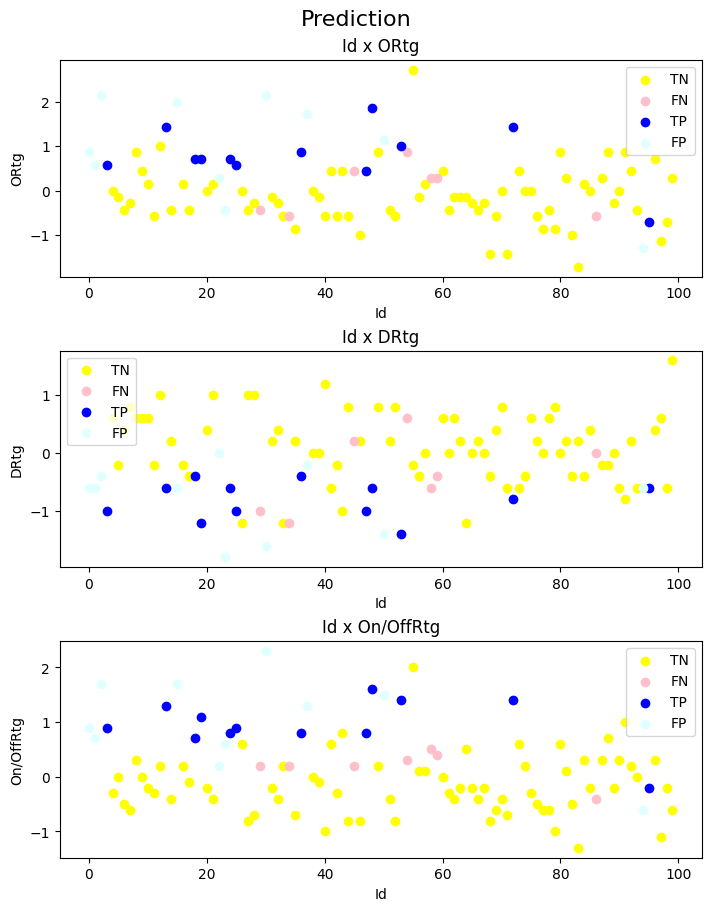

In [20]:
# Training and test process (Robust scaling) with refcv feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=23)

print("Training and test process (Robust scaling) with refcv feature selection")

selected_features_LR_rfecv = select_features_rfecv(model_LR, training_per_100_poss_scaled.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_LR, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), selected_features_LR_rfecv, True)

### Select k-best

Training and test process (Robust scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.2327429147611464
Cross validation mean recall on training set:  0.8752380952380954
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 83
Predicted positives: 17
True negatives (how many of the predicts are really negative):  77
False negatives (predicted negatives that are actual positive):  6
True positives (how many of the predicts are really positive):  13
False positives (predicted positives that are actual negative):  4
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76    

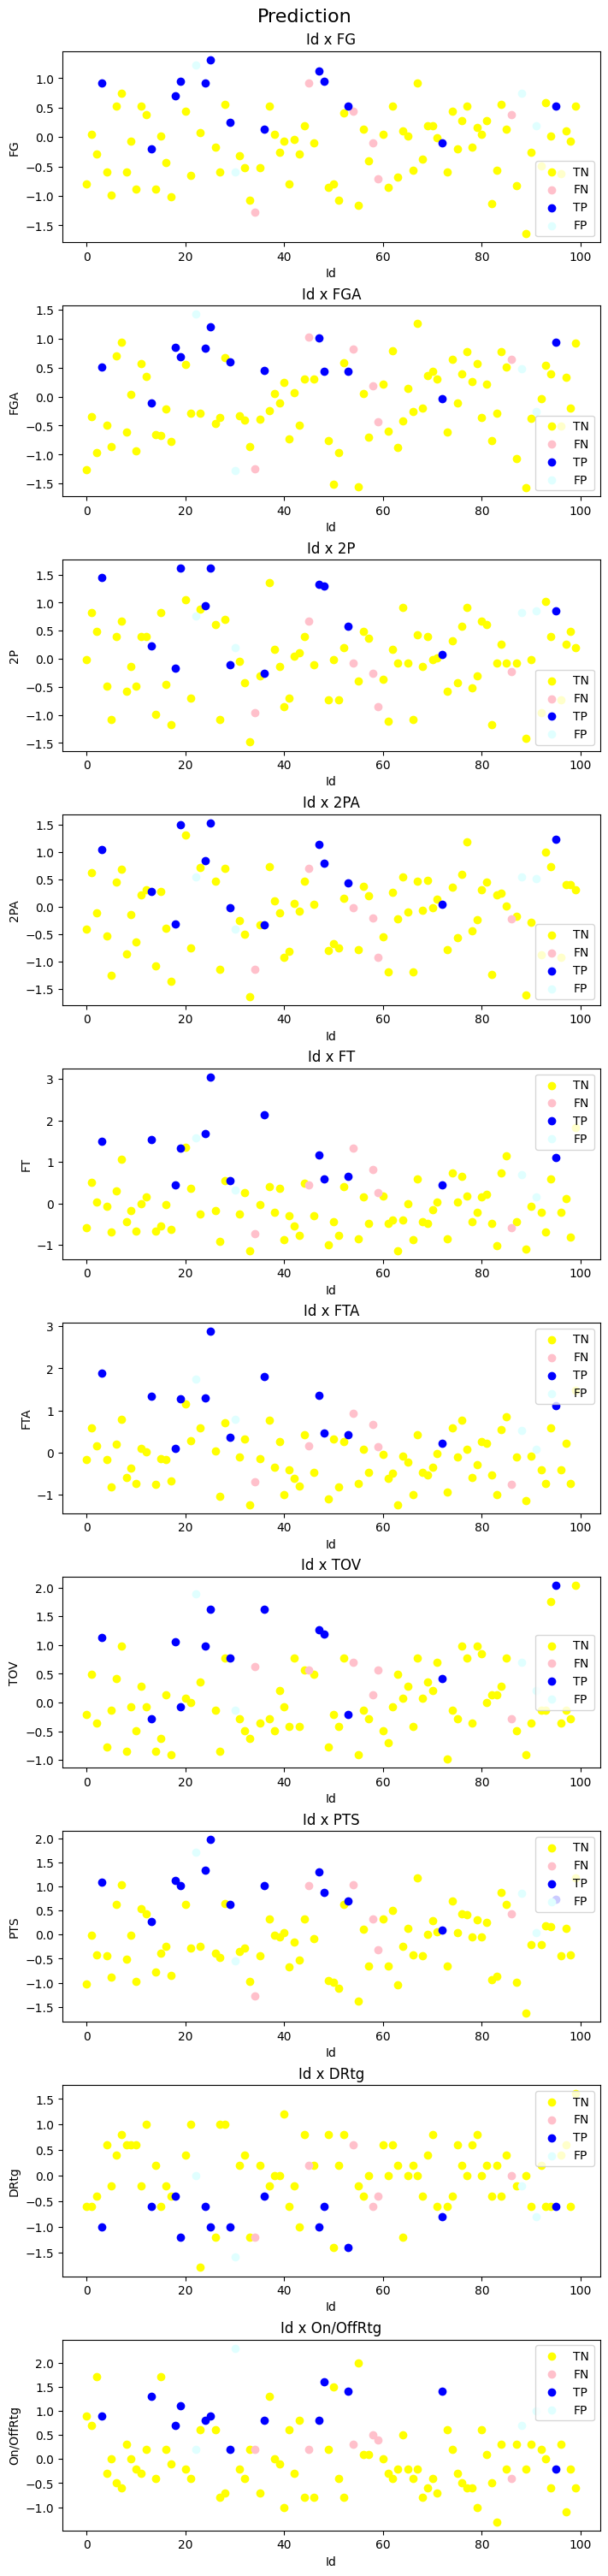

In [21]:
# Training and test process (Robust scaling) with skb feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=23)

print("Training and test process (Robust scaling) with skb feature selection")

selected_features_LR_skb = select_features_skb(training_per_100_poss_scaled.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_LR, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), selected_features_LR_skb, True)

### Select From Model

In [22]:
# Training and test process (Robust scaling) with sfm feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=23)

print("Training and test process (Robust scaling) with sfm feature selection")

selected_features_LR_sfm = select_features_sfm(model_LR, training_per_100_poss_scaled.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_LR, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), selected_features_LR_sfm, False)

Training and test process (Robust scaling) with sfm feature selection
Optimal number of features: 12
Selected features:
['FG%', '3PA', '3P%', 'FT', 'FTA', 'ORB', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.269547204065417
Cross validation mean recall on training set:  0.8600000000000001
Feature Columns (list) used for training and test process: 
['FG%', '3PA', '3P%', 'FT', 'FTA', 'ORB', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 78
Predicted positives: 22
True negatives (how many of the predicts are really negative):  71
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  10
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Ro

## Logistic Regression with manual feature selection

In [23]:
# My feature selection

selected_features_manual = ['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']

### Training and test process 

In [24]:
# Training and test process (Robust scaling) with manual feature selection

model_LR = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=23)

print("Training and test process (Robust scaling) with manual feature selection")

train_test_pipeline(model_LR, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), selected_features_manual, False)

Training and test process (Robust scaling) with manual feature selection
Cross validation mean precision on training set:  0.23984026000806083
Cross validation mean recall on training set:  0.8752380952380954
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 86
Predicted positives: 14
True negatives (how many of the predicts are really negative):  78
False negatives (predicted negatives that are actual positive):  8
True positives (how many of the predicts are really positive):  11
False positives (predicted positives that are actual negative):  3
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length:

____________________________________________________________________________________________________________________

# Support Vector Classifier

### Model definition

In [57]:
# Model definition

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear', random_state=23)

## Support Vector Classifier with no feature selection

In [27]:
# Training and test process (Robust scaling) with no feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear', random_state=23)

print("Training and test process (Robust scaling) with no feature selection")

train_test_pipeline(model_SVC, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), valid_per_100_poss_columns[:], False)

Training and test process (Robust scaling) with no feature selection
Cross validation mean precision on training set:  0.2507505905119668
Cross validation mean recall on training set:  0.8466666666666669
Feature Columns (list) used for training and test process: 
['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 78
Predicted positives: 22
True negatives (how many of the predicts are really negative):  70
False negatives (predicted negatives that are actual positive):  8
True positives (how many of the predicts are really positive):  11
False positives (predicted positives that are actual negative):  11
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        A

## Support Vector Classifier with feature selection

### RFECV

In [28]:
# Training and test process (Robust scaling) with rfecv feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear', random_state=23)

print("Training and test process (Robust scaling) with rfecv feature selection")

selected_features_SVC_rfecv = select_features_rfecv(model_SVC, training_per_100_poss_scaled.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_SVC, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), selected_features_SVC_rfecv, False)

Training and test process (Robust scaling) with rfecv feature selection
Optimal number of features: 15
Selected features:
['FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TRB', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.27335150645624107
Cross validation mean recall on training set:  0.8609523809523811
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TRB', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 77
Predicted positives: 23
True negatives (how many of the predicts are really negative):  70
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  11
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart

### Select k-best

In [29]:
# Training and test process (Robust scaling) with skb feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear', random_state=23)

print("Training and test process (Robust scaling) with skb feature selection")

selected_features_SVC_skb = select_features_skb(training_per_100_poss_scaled.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_SVC, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), selected_features_SVC_skb, False)

Training and test process (Robust scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.22891481399955974
Cross validation mean recall on training set:  0.8752380952380954
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 81
Predicted positives: 19
True negatives (how many of the predicts are really negative):  76
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  5
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76   

### Selected From Model

In [30]:
# Training and test process (Robust scaling) with sfm feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear', random_state=23)

print("Training and test process (Robust scaling) with sfm feature selection")

selected_features_SVC_sfm = select_features_sfm(model_SVC, training_per_100_poss_scaled.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_SVC, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), selected_features_SVC_sfm, False)

Training and test process (Robust scaling) with sfm feature selection
Optimal number of features: 11
Selected features:
['FGA', 'FG%', '3PA', 'FT', 'FTA', 'FT%', 'TOV', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.26868349042262085
Cross validation mean recall on training set:  0.8885714285714286
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', '3PA', 'FT', 'FTA', 'FT%', 'TOV', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 82
Predicted positives: 18
True negatives (how many of the predicts are really negative):  75
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  6
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            

## Support Vector Classifier with manual feature selection

In [31]:
# My feature selection

selected_features_manual = ['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']

### Training and test process

In [32]:
# Training and test process (Robust scaling) with manual feature selection

model_SVC = svm.SVC(class_weight='balanced', probability=True, kernel='linear', random_state=23)

print("Training and test process (Robust scaling) with manual feature selection")

train_test_pipeline(model_SVC, training_per_100_poss_scaled.copy(), test_per_100_poss_scaled.copy(), selected_features_manual, False)

Training and test process (Robust scaling) with manual feature selection
Cross validation mean precision on training set:  0.2620365714232054
Cross validation mean recall on training set:  0.8752380952380954
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 86
Predicted positives: 14
True negatives (how many of the predicts are really negative):  78
False negatives (predicted negatives that are actual positive):  8
True positives (how many of the predicts are really positive):  11
False positives (predicted positives that are actual negative):  3
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 

_______________________________________________________________________________________________________________________

# Decision tree

### Model definition

In [33]:
# Model definition

model_DTC = tree.DecisionTreeClassifier(random_state=23)
model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

## Decision tree with no feature selection

In [34]:
# Training and test process (no scaling and no weighted classes) with no feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with no feature selection")

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:], False)

Training and test process (no scaling and no weighted classes) with no feature selection
Cross validation mean precision on training set:  0.43735294117647056
Cross validation mean recall on training set:  0.37523809523809526
Feature Columns (list) used for training and test process: 
['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  80
False negatives (predicted negatives that are actual positive):  5
True positives (how many of the predicts are really positive):  14
False positives (predicted positives that are actual negative):  1
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Juli

In [35]:
# Training and test process (no scaling) with no feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no scaling) with no feature selection")

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:], False)

Training and test process (no scaling) with no feature selection
Cross validation mean precision on training set:  0.4213273001508296
Cross validation mean recall on training set:  0.3476190476190476
Feature Columns (list) used for training and test process: 
['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 84
Predicted positives: 16
True negatives (how many of the predicts are really negative):  75
False negatives (predicted negatives that are actual positive):  9
True positives (how many of the predicts are really positive):  10
False positives (predicted positives that are actual negative):  6
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron 

## Decision tree feature selection

### RFECV

In [36]:
# Training and test process (no scaling and no weighted classes) with rfecv feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with rfecv feature selection")

selected_features_DTC_rfecv = select_features_rfecv(model_DTC, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_DTC_rfecv, False)

Training and test process (no scaling and no weighted classes) with rfecv feature selection
Optimal number of features: 17
Selected features:
['FG%', '3P%', '2PA', '2P%', 'FT', 'FTA', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.5181385281385282
Cross validation mean recall on training set:  0.4742857142857143
Feature Columns (list) used for training and test process: 
['FG%', '3P%', '2PA', '2P%', 'FT', 'FTA', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 83
Predicted positives: 17
True negatives (how many of the predicts are really negative):  79
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  2
PLayer not Hof (True Negatives):
26      Derrick Favo

In [37]:
# Training and test process (no scaling) with rfecv feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no scaling) with rfecv feature selection")

selected_features_DTC_rfecv = select_features_rfecv(model_DTC, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_DTC_rfecv, False)

Training and test process (no scaling) with rfecv feature selection
Optimal number of features: 8
Selected features:
['3P%', 'FTA', 'TRB', 'TOV', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.5280652680652681
Cross validation mean recall on training set:  0.45714285714285713
Feature Columns (list) used for training and test process: 
['3P%', 'FTA', 'TRB', 'TOV', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  11
True positives (how many of the predicts are really positive):  8
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31       

### Select k-best 

In [38]:
# Training and test process (no scaling and no weighted classes) with skb feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with skb feature selection")

selected_features_DTC_skb = select_features_skb(training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_DTC_skb, False)

Training and test process (no scaling and no weighted classes) with skb feature selection
Optimal number of features: 10
Selected features:
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.45071154898741106
Cross validation mean recall on training set:  0.4133333333333333
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  78
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  3
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
        

In [39]:
# Training and test process (no scaling) with skb feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no scaling) with skb feature selection")

selected_features_DTC_skb = select_features_skb(training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_DTC_skb, False)

Training and test process (no scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.3424117987275882
Cross validation mean recall on training set:  0.33333333333333337
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  75
False negatives (predicted negatives that are actual positive):  10
True positives (how many of the predicts are really positive):  9
False positives (predicted positives that are actual negative):  6
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       

### Select From Model

In [40]:
# Training and test process (no feature selection) with sfm feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no feature selection) with sfm feature selection")

selected_features_DTC_sfm = select_features_sfm(model_DTC, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_DTC_sfm, False)

Training and test process (no feature selection) with sfm feature selection
Optimal number of features: 11
Selected features:
['FG%', '3P%', '2PA', 'DRB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.47224471434997745
Cross validation mean recall on training set:  0.4161904761904762
Feature Columns (list) used for training and test process: 
['FG%', '3P%', '2PA', 'DRB', 'AST', 'STL', 'BLK', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 84
Predicted positives: 16
True negatives (how many of the predicts are really negative):  76
False negatives (predicted negatives that are actual positive):  8
True positives (how many of the predicts are really positive):  11
False positives (predicted positives that are actual negative):  5
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
    

In [41]:
# Training and test process (no feature selection and weighted classes) with sfm feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no feature selection and weighted classes) with sfm feature selection")

selected_features_DTC_sfm = select_features_sfm(model_DTC, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_DTC_sfm, False)

Training and test process (no feature selection and weighted classes) with sfm feature selection
Optimal number of features: 4
Selected features:
['TOV', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.3862271062271062
Cross validation mean recall on training set:  0.40095238095238095
Feature Columns (list) used for training and test process: 
['TOV', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 83
Predicted positives: 17
True negatives (how many of the predicts are really negative):  76
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  5
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto

## Decision tree with manual feature selection

In [38]:
# My feature selection

selected_features_manual = ['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']

In [43]:
# Training and test process (no scaling and no weighted classes) with manual feature selection

model_DTC = tree.DecisionTreeClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with manual feature selection")

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_manual, False)

Training and test process (no scaling and no weighted classes) with manual feature selection
Cross validation mean precision on training set:  0.4386868686868687
Cross validation mean recall on training set:  0.44571428571428573
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 81
Predicted positives: 19
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
N

In [40]:
# Training and test process (no scaling) with manual feature selection

model_DTC = tree.DecisionTreeClassifier(class_weight='balanced', random_state=23)

print("Training and test process (no scaling) with manual feature selection")

train_test_pipeline(model_DTC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_manual, False)

Training and test process (no scaling) with manual feature selection
Cross validation mean precision on training set:  0.388921568627451
Cross validation mean recall on training set:  0.40285714285714286
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 81
Predicted positives: 19
True negatives (how many of the predicts are really negative):  74
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  7
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 74, 

# Random Forest Classifier

## Model definition

In [17]:
# Model definition

model_RFC = RandomForestClassifier(random_state=23)

## Random Forest Classifier with no feature selection

In [18]:
# Training and test process (no scaling and no weighted classes) with no feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with no feature selection")

train_test_pipeline(model_RFC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:], False)

Training and test process (no scaling and no weighted classes) with no feature selection
Cross validation mean precision on training set:  0.7833333333333333
Cross validation mean recall on training set:  0.31714285714285717
Feature Columns (list) used for training and test process: 
['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 90
Predicted positives: 10
True negatives (how many of the predicts are really negative):  81
False negatives (predicted negatives that are actual positive):  9
True positives (how many of the predicts are really positive):  10
False positives (predicted positives that are actual negative):  0
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Juliu

## Random forest with feature selection

### RFECV

In [48]:
# Training and test process (no scaling and no weighted classes) with rfecv feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with rfecv feature selection")

selected_features_RFC_rfecv = select_features_rfecv(model_RFC, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_RFC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_RFC_rfecv, False)

Training and test process (no scaling and no weighted classes) with rfecv feature selection
Optimal number of features: 10
Selected features:
['FG', 'FGA', '2P', 'FT', 'FTA', 'DRB', 'AST', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.7050000000000001
Cross validation mean recall on training set:  0.3885714285714286
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', 'FT', 'FTA', 'DRB', 'AST', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  78
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  3
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
       

### Select k-best

In [50]:
# Training and test process (no scaling and no weighted classes) with skb feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with skb feature selection")

selected_features_RFC_skb = select_features_skb(training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_RFC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_RFC_skb, False)

Training and test process (no scaling and no weighted classes) with skb feature selection
Optimal number of features: 10
Selected features:
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.7124242424242424
Cross validation mean recall on training set:  0.3028571428571428
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 86
Predicted positives: 14
True negatives (how many of the predicts are really negative):  80
False negatives (predicted negatives that are actual positive):  6
True positives (how many of the predicts are really positive):  13
False positives (predicted positives that are actual negative):  1
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
         

### Select From Model

In [52]:
# Training and test process (no scaling and no weighted classes) with sfm feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process (no scaling and no weighted classes) with sfm feature selection")

selected_features_RFC_sfm = select_features_sfm(model_RFC, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_RFC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_RFC_sfm,  False)

Training and test process (no scaling and no weighted classes) with sfm feature selection
Optimal number of features: 8
Selected features:
['FG', '2P', 'FT', 'DRB', 'AST', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.6961904761904762
Cross validation mean recall on training set:  0.3180952380952381
Feature Columns (list) used for training and test process: 
['FG', '2P', 'FT', 'DRB', 'AST', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  79
False negatives (predicted negatives that are actual positive):  6
True positives (how many of the predicts are really positive):  13
False positives (predicted positives that are actual negative):  2
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius

## Random Forest with manual feature selection

### My feature selection

In [54]:
# My feature selection

selected_features_manual = ['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']

### Training and test process

In [55]:
# Training and test process (no scaling and no weighted classes) with manual feature selection

model_RFC = RandomForestClassifier(random_state=23)

print("Training and test process with manual feature selection")

train_test_pipeline(model_RFC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_manual, False)

Training and test process with manual feature selection
Cross validation mean precision on training set:  0.8123376623376624
Cross validation mean recall on training set:  0.36190476190476184
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  78
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  3
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 78, dtype: objec

# Adaboost

## Model definition

In [59]:
# Model definition

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

## Adaboost with no feature selection

In [60]:
# Training and test process (no scaling) with no feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with no feature selection")

train_test_pipeline(model_ABC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:], False)

Training and test process (no scaling) with no feature selection
Cross validation mean precision on training set:  0.6733333333333333
Cross validation mean recall on training set:  0.4438095238095238
Feature Columns (list) used for training and test process: 
['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 81
Predicted positives: 19
True negatives (how many of the predicts are really negative):  77
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  4
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron 

## Adaboost with feature selection

### RFECV

In [62]:
# Training and test process (no scaling) with rfecv feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with rfecv feature selection")

selected_features_ABC_rfecv = select_features_rfecv(base_estimator, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_ABC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_ABC_rfecv, False)

Training and test process (no scaling) with rfecv feature selection
Optimal number of features: 4
Selected features:
['PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.5484415584415585
Cross validation mean recall on training set:  0.3857142857142858
Feature Columns (list) used for training and test process: 
['PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 90
Predicted positives: 10
True negatives (how many of the predicts are really negative):  81
False negatives (predicted negatives that are actual positive):  9
True positives (how many of the predicts are really positive):  10
False positives (predicted positives that are actual negative):  0
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy

### Select k-best

In [64]:
# Training and test process (no scaling) with skb feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with skb feature selection")

selected_features_ABC_skb = select_features_skb(training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_ABC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_ABC_skb, False)

Training and test process (no scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.5795995670995671
Cross validation mean recall on training set:  0.35809523809523813
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 84
Predicted positives: 16
True negatives (how many of the predicts are really negative):  78
False negatives (predicted negatives that are actual positive):  6
True positives (how many of the predicts are really positive):  13
False positives (predicted positives that are actual negative):  3
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       

### Select from model

In [66]:
# Training and test process (no scaling) with sfm feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with rfecv feature selection")

selected_features_ABC_sfm = select_features_sfm(model_ABC, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_ABC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_ABC_sfm, False)

Training and test process (no scaling) with rfecv feature selection
Optimal number of features: 6
Selected features:
['DRB', 'AST', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.6438661338661339
Cross validation mean recall on training set:  0.42952380952380953
Feature Columns (list) used for training and test process: 
['DRB', 'AST', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 80
Predicted positives: 20
True negatives (how many of the predicts are really negative):  76
False negatives (predicted negatives that are actual positive):  4
True positives (how many of the predicts are really positive):  15
False positives (predicted positives that are actual negative):  5
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Po

## Adaboost with manual feature selection

In [71]:
# My feature selection

selected_features_manual = ['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']

### Training and test process

In [72]:
# Training and test process (no scaling) with manual feature selection

base_estimator = tree.DecisionTreeClassifier(max_depth=1)
model_ABC = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME', random_state=23)

print("Training and test process (no scaling) with manual feature selection")

train_test_pipeline(model_ABC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_manual, False)

Training and test process (no scaling) with manual feature selection
Cross validation mean precision on training set:  0.6301587301587303
Cross validation mean recall on training set:  0.4161904761904762
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  79
False negatives (predicted negatives that are actual positive):  6
True positives (how many of the predicts are really positive):  13
False positives (predicted positives that are actual negative):  2
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 79, 

# Gradientboost

## Model definition

In [74]:
# Model definition

model_GBC = GradientBoostingClassifier(random_state=23)

## Gradient boost with no feature selection

In [75]:
# Training and test process (no scaling) with no feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with no feature selection")

train_test_pipeline(model_GBC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:], False)

Training and test process (no scaling) with no feature selection
Cross validation mean precision on training set:  0.762063492063492
Cross validation mean recall on training set:  0.4428571428571429
Feature Columns (list) used for training and test process: 
['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 86
Predicted positives: 14
True negatives (how many of the predicts are really negative):  77
False negatives (predicted negatives that are actual positive):  9
True positives (how many of the predicts are really positive):  10
False positives (predicted positives that are actual negative):  4
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron G

## Gradient boost with feature selection

### RFECV

In [81]:
# Training and test process (no scaling) with rfecv feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with rfecv feature selection")

selected_features_GBC_rfecv = select_features_rfecv(model_GBC,
                                                    training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_GBC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_GBC_rfecv, False)

Training and test process (no scaling) with rfecv feature selection
Optimal number of features: 15
Selected features:
['FG', 'FGA', '2P', '2PA', '2P%', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.7271794871794872
Cross validation mean recall on training set:  0.4571428571428572
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', '2PA', '2P%', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 89
Predicted positives: 11
True negatives (how many of the predicts are really negative):  81
False negatives (predicted negatives that are actual positive):  8
True positives (how many of the predicts are really positive):  11
False positives (predicted positives that are actual negative):  0
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     

### Select k-best

In [77]:
# Training and test process (no scaling) with skb feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with skb feature selection")

selected_features_GBC_skb = select_features_skb(training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_GBC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_GBC_skb, False)

Training and test process (no scaling) with skb feature selection
Optimal number of features: 10
Selected features:
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.6698412698412699
Cross validation mean recall on training set:  0.3866666666666667
Feature Columns (list) used for training and test process: 
['FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 85
Predicted positives: 15
True negatives (how many of the predicts are really negative):  78
False negatives (predicted negatives that are actual positive):  7
True positives (how many of the predicts are really positive):  12
False positives (predicted positives that are actual negative):  3
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       J

### Select From Model

In [79]:
# Training and test process (no scaling) with sfm feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with sfm feature selection")

selected_features_GBC_sfm = select_features_sfm(model_GBC, training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_pipeline(model_GBC, training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_GBC_sfm, False)

Training and test process (no scaling) with sfm feature selection
Optimal number of features: 5
Selected features:
['2P', 'AST', 'PTS', 'DRtg', 'On/OffRtg']
Cross validation mean precision on training set:  0.6871861471861471
Cross validation mean recall on training set:  0.4723809523809524
Feature Columns (list) used for training and test process: 
['2P', 'AST', 'PTS', 'DRtg', 'On/OffRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 83
Predicted positives: 17
True negatives (how many of the predicts are really negative):  77
False negatives (predicted negatives that are actual positive):  6
True positives (how many of the predicts are really positive):  13
False positives (predicted positives that are actual negative):  4
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40      

## GradientBoost with manual feature selection

In [36]:
# My feature selection

selected_features_manual = ['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']

### Training and test process

In [80]:
# Training and test process (no scaling) with manual feature selection

model_GBC = GradientBoostingClassifier(random_state=23)

print("Training and test process (no scaling) with manual feature selection")

train_test_pipeline(model_GBC, training_per_100_poss_prepared, test_per_100_poss_prepared, selected_features_manual, False)

Training and test process (no scaling) with manual feature selection
Cross validation mean precision on training set:  0.7064801864801865
Cross validation mean recall on training set:  0.41714285714285715
Feature Columns (list) used for training and test process: 
['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']
Actual negatives: 81
Actual positives: 19
Predicted negatives: 90
Predicted positives: 10
True negatives (how many of the predicts are really negative):  79
False negatives (predicted negatives that are actual positive):  11
True positives (how many of the predicts are really positive):  8
False positives (predicted positives that are actual negative):  2
PLayer not Hof (True Negatives):
26      Derrick Favors
80    Domantas Sabonis
82        Marcus Smart
68     Markieff Morris
77        Derrick Rose
            ...       
76       Julius Randle
31        Aaron Gordon
73     Otto Porter Jr.
40         Buddy Hield
83           Ish Smith
Name: Player, Length: 79,

# XGBoost

In [ ]:
def train_test_xboost_pipeline(train_n_df, test_n_df, sel_features, plotted):
    X_train, y_train = train_n_df[sel_features], train_n_df['Hof']

    X_test, y_test = test_n_df[sel_features], test_n_df['Hof']

    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)

    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 5,
        'eta': 0.1,
        'subsample': 0.7,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'lambda': 1,
        'alpha': 0,
        'seed': 23
    }

    num_rounds = 100
    bst = xgb.train(params, dtrain, num_rounds)

    preds = bst.predict(dtest)
    y_pred = pd.Series([1 if p > 0.5 else 0 for p in preds], index=test_n_df.index)

    fig, ax, class_p = evaluating_classification_model(y_pred, y_test, test_n_df, sel_features, 'Prediction', plotted)
    # y_proba_df, y_proba_diff_df = probability_hof_comparing(bst, X_test, test_n_df)
    # return { 'figure' : fig,
    #          'axes' : ax,
    #          'classes_p' : class_p}

## XGboost with no feature selection

In [ ]:
# Training and test process (no scaling and no weighted classes) with no feature selection

print("Training and test process (no scaling and no weighted classes) with no feature selection")

train_test_xboost_pipeline(training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), valid_per_100_poss_columns, False)

## XGboost with Select k-best feature selection

In [ ]:
# Training and test process (no scaling and no weighted classes) with manual feature selection

print("Training and test process (no scaling and no weighted classes) with skb feature selection")

selected_features_skb = select_features_skb(training_per_100_poss_prepared.copy(), valid_per_100_poss_columns[:])

train_test_xboost_pipeline(training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_skb,  False)

## XGboost with manual feature selection

In [ ]:
# Training and test process (no scaling and no weighted classes) with manual feature selection

print("Training and test process (no scaling and no weighted classes) with manual feature selection")

selected_features_manual = ['FGA', 'FG%', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'ORtg', 'DRtg']

train_test_xboost_pipeline(training_per_100_poss_prepared.copy(), test_per_100_poss_prepared.copy(), selected_features_manual, False)